In [1]:
import sys
sys.path.append("../../")
import cv2

In [10]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torchsummary import summary
import albumentations as A
from torch_lr_finder import LRFinder

from dataloader import get_CIFAR10dataset, CIFAR10_dataset, get_transforms, get_dataloader, get_CIFAR10_musigma
from models.custom_resnet import CustomResnet
from train import train_epoch, test_epoch
from utils import show_samples

# Set Global Config

In [3]:
SEED = 1

# CUDA?
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("CUDA Available?", device)

# For reproducibility
torch.manual_seed(SEED)

if device=='cuda':
    torch.cuda.manual_seed(SEED)

CUDA Available? cuda


# Get the data 

In [4]:
train_data = get_CIFAR10dataset(root="../../data", train_flag=True, download_flag=True)
test_data = get_CIFAR10dataset(root="../../data", train_flag=False, download_flag=True)

Files already downloaded and verified
Files already downloaded and verified


# Create CIFAR10- Dataset + DataLoader with transforms

In [5]:
bs = 512
train_tfms_list = [
                  A.PadIfNeeded(min_height=40, min_width=40, border_mode=0, value=get_CIFAR10_musigma()[0], p=1.0), #border_mode=0 needs fill value
                  A.RandomCrop(height=32, width=32, p=1.0),
                  A.HorizontalFlip(p=0.5),
                  A.CoarseDropout(
                    max_holes=1,
                    max_height=8,
                    max_width=8,
                    min_holes=1,
                    min_height=8,
                    min_width=8,
                    fill_value=get_CIFAR10_musigma()[0],
                    mask_fill_value=None,
                    p=0.5,
                    )
                  ]


train_tfms = get_transforms(basic=False, tfms_list=train_tfms_list)
test_tfms = get_transforms(basic=True, tfms_list=None)

train_ds = CIFAR10_dataset(data=train_data.data, targets=train_data.targets, transforms=train_tfms)
test_ds = CIFAR10_dataset(data=test_data.data, targets=test_data.targets, transforms=test_tfms)

train_dl = get_dataloader(train_ds, bs_cuda=bs, bs_cpu=64, device=device)
test_dl = get_dataloader(test_ds, bs_cuda=bs, bs_cpu=64, device=device)

# visualize some samples from training set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


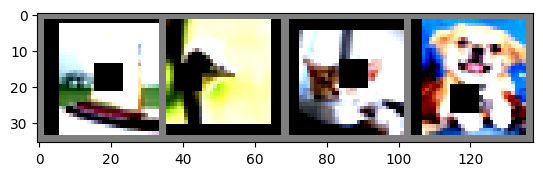

ship  bird  cat   dog  


In [6]:
# get some random training images
dataiter = iter(train_dl)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# show images
show_samples(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Build the Network

In [7]:
model = CustomResnet(inch=3, num_classes=10).to(device)
# sanity check
xx = torch.rand(1,3,32,32).to(device)
yy = model(xx)
yy.shape

torch.Size([1, 10])

In [8]:
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
         Resblock-14          [-1, 128,

# LR Finder

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.33E-01


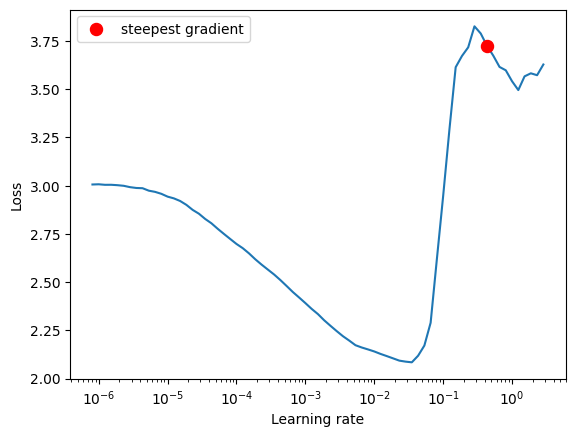

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_dl, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

**Summary**
- use lower lr = 1e-4 and upper lr = 1e-3 for once cycle scheduling

# Train the model

## EXP1

In [17]:
EPOCHS = 24

In [18]:
criterion = nn.CrossEntropyLoss()
criterion_test = nn.CrossEntropyLoss(reduction = 'sum')
optimizer = optim.Adam(model.parameters(), lr=1e-7)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=1e-3, epochs=EPOCHS, steps_per_epoch=len(train_dl), pct_start=0.2, div_factor=10)

train_stats = {}
test_stats = {}
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_epoch(model, device, train_dl, optimizer, criterion, epoch, train_stats)
    scheduler.step()
    test_epoch(model, device, test_dl, criterion_test, test_stats)


  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.4271705150604248 Batch_id=97 Accuracy=42.32: 100%|██████████████████████████████| 98/98 [00:11<00:00,  8.33it/s]
Loss=1.3301280736923218 Batch_id=0 Accuracy=50.98:   1%|▎                               | 1/98 [00:00<00:11,  8.20it/s]


Test set: Average loss: 1.4139, Accuracy: 4924/10000 (49.24%)

EPOCH: 1


Loss=1.0524332523345947 Batch_id=97 Accuracy=58.49: 100%|██████████████████████████████| 98/98 [00:11<00:00,  8.66it/s]
Loss=1.0871177911758423 Batch_id=0 Accuracy=62.11:   1%|▎                               | 1/98 [00:00<00:11,  8.47it/s]


Test set: Average loss: 1.0679, Accuracy: 6182/10000 (61.82%)

EPOCH: 2


Loss=0.9233520030975342 Batch_id=97 Accuracy=66.12: 100%|██████████████████████████████| 98/98 [00:11<00:00,  8.57it/s]
Loss=0.8663256168365479 Batch_id=0 Accuracy=67.38:   1%|▎                               | 1/98 [00:00<00:11,  8.77it/s]


Test set: Average loss: 0.8655, Accuracy: 6962/10000 (69.62%)

EPOCH: 3


Loss=0.8315924406051636 Batch_id=97 Accuracy=71.01: 100%|██████████████████████████████| 98/98 [00:11<00:00,  8.41it/s]
Loss=0.7490741014480591 Batch_id=0 Accuracy=72.66:   1%|▎                               | 1/98 [00:00<00:11,  8.40it/s]


Test set: Average loss: 0.7780, Accuracy: 7263/10000 (72.63%)

EPOCH: 4


Loss=0.665644109249115 Batch_id=97 Accuracy=74.91: 100%|███████████████████████████████| 98/98 [00:11<00:00,  8.36it/s]
Loss=0.635718822479248 Batch_id=0 Accuracy=77.15:   1%|▎                                | 1/98 [00:00<00:11,  8.31it/s]


Test set: Average loss: 0.6867, Accuracy: 7571/10000 (75.71%)

EPOCH: 5


Loss=0.7236994504928589 Batch_id=97 Accuracy=77.45: 100%|██████████████████████████████| 98/98 [00:11<00:00,  8.27it/s]
Loss=0.6033105254173279 Batch_id=0 Accuracy=78.52:   1%|▎                               | 1/98 [00:00<00:12,  8.07it/s]


Test set: Average loss: 0.6565, Accuracy: 7694/10000 (76.94%)

EPOCH: 6


Loss=0.5914109349250793 Batch_id=97 Accuracy=79.34: 100%|██████████████████████████████| 98/98 [00:12<00:00,  8.14it/s]
Loss=0.5131746530532837 Batch_id=0 Accuracy=82.03:   1%|▎                               | 1/98 [00:00<00:11,  8.42it/s]


Test set: Average loss: 0.6244, Accuracy: 7799/10000 (77.99%)

EPOCH: 7


Loss=0.49900907278060913 Batch_id=97 Accuracy=81.21: 100%|█████████████████████████████| 98/98 [00:12<00:00,  8.08it/s]
Loss=0.500974714756012 Batch_id=0 Accuracy=80.66:   1%|▎                                | 1/98 [00:00<00:11,  8.33it/s]


Test set: Average loss: 0.5864, Accuracy: 7954/10000 (79.54%)

EPOCH: 8


Loss=0.5380673408508301 Batch_id=97 Accuracy=82.31: 100%|██████████████████████████████| 98/98 [00:12<00:00,  7.85it/s]
Loss=0.5199567675590515 Batch_id=0 Accuracy=83.01:   1%|▎                               | 1/98 [00:00<00:12,  7.54it/s]


Test set: Average loss: 0.5700, Accuracy: 8087/10000 (80.87%)

EPOCH: 9


Loss=0.4719240665435791 Batch_id=97 Accuracy=83.75: 100%|██████████████████████████████| 98/98 [00:12<00:00,  7.66it/s]
Loss=0.4032632112503052 Batch_id=0 Accuracy=85.35:   1%|▎                               | 1/98 [00:00<00:13,  7.41it/s]


Test set: Average loss: 0.5320, Accuracy: 8180/10000 (81.80%)

EPOCH: 10


Loss=0.4424283504486084 Batch_id=97 Accuracy=85.12: 100%|██████████████████████████████| 98/98 [00:13<00:00,  7.40it/s]
Loss=0.4272673726081848 Batch_id=0 Accuracy=85.16:   1%|▎                               | 1/98 [00:00<00:13,  7.14it/s]


Test set: Average loss: 0.5106, Accuracy: 8259/10000 (82.59%)

EPOCH: 11


Loss=0.4121241867542267 Batch_id=97 Accuracy=86.19: 100%|██████████████████████████████| 98/98 [00:13<00:00,  7.34it/s]
Loss=0.4012131989002228 Batch_id=0 Accuracy=86.52:   1%|▎                               | 1/98 [00:00<00:12,  7.46it/s]


Test set: Average loss: 0.4997, Accuracy: 8332/10000 (83.32%)

EPOCH: 12


Loss=0.45600980520248413 Batch_id=97 Accuracy=86.78: 100%|█████████████████████████████| 98/98 [00:13<00:00,  7.30it/s]
Loss=0.3903787136077881 Batch_id=0 Accuracy=86.72:   1%|▎                               | 1/98 [00:00<00:13,  7.25it/s]


Test set: Average loss: 0.5029, Accuracy: 8294/10000 (82.94%)

EPOCH: 13


Loss=0.34801170229911804 Batch_id=97 Accuracy=87.72: 100%|█████████████████████████████| 98/98 [00:13<00:00,  7.23it/s]
Loss=0.3616517186164856 Batch_id=0 Accuracy=87.70:   1%|▎                               | 1/98 [00:00<00:13,  7.30it/s]


Test set: Average loss: 0.4842, Accuracy: 8325/10000 (83.25%)

EPOCH: 14


Loss=0.34428924322128296 Batch_id=97 Accuracy=88.43: 100%|█████████████████████████████| 98/98 [00:13<00:00,  7.19it/s]
Loss=0.31196117401123047 Batch_id=0 Accuracy=90.23:   1%|▎                              | 1/98 [00:00<00:13,  7.25it/s]


Test set: Average loss: 0.4788, Accuracy: 8421/10000 (84.21%)

EPOCH: 15


Loss=0.36662182211875916 Batch_id=97 Accuracy=89.09: 100%|█████████████████████████████| 98/98 [00:13<00:00,  7.08it/s]
Loss=0.352965772151947 Batch_id=0 Accuracy=88.67:   1%|▎                                | 1/98 [00:00<00:12,  7.70it/s]


Test set: Average loss: 0.4750, Accuracy: 8361/10000 (83.61%)

EPOCH: 16


Loss=0.3248607814311981 Batch_id=97 Accuracy=89.90: 100%|██████████████████████████████| 98/98 [00:14<00:00,  6.89it/s]
Loss=0.29348474740982056 Batch_id=0 Accuracy=89.84:   1%|▎                              | 1/98 [00:00<00:14,  6.85it/s]


Test set: Average loss: 0.4390, Accuracy: 8542/10000 (85.42%)

EPOCH: 17


Loss=0.27187153697013855 Batch_id=97 Accuracy=90.30: 100%|█████████████████████████████| 98/98 [00:14<00:00,  6.94it/s]
Loss=0.2726097106933594 Batch_id=0 Accuracy=91.21:   1%|▎                               | 1/98 [00:00<00:14,  6.89it/s]


Test set: Average loss: 0.4542, Accuracy: 8509/10000 (85.09%)

EPOCH: 18


Loss=0.29279327392578125 Batch_id=97 Accuracy=90.87: 100%|█████████████████████████████| 98/98 [00:14<00:00,  6.97it/s]
Loss=0.25268301367759705 Batch_id=0 Accuracy=90.82:   1%|▎                              | 1/98 [00:00<00:15,  6.21it/s]


Test set: Average loss: 0.4351, Accuracy: 8567/10000 (85.67%)

EPOCH: 19


Loss=0.21682961285114288 Batch_id=97 Accuracy=91.45: 100%|█████████████████████████████| 98/98 [00:14<00:00,  6.95it/s]
Loss=0.21486599743366241 Batch_id=0 Accuracy=93.16:   1%|▎                              | 1/98 [00:00<00:14,  6.66it/s]


Test set: Average loss: 0.4432, Accuracy: 8515/10000 (85.15%)

EPOCH: 20


Loss=0.19100020825862885 Batch_id=97 Accuracy=91.81: 100%|█████████████████████████████| 98/98 [00:14<00:00,  6.87it/s]
Loss=0.19610509276390076 Batch_id=0 Accuracy=93.36:   1%|▎                              | 1/98 [00:00<00:15,  6.41it/s]


Test set: Average loss: 0.4198, Accuracy: 8608/10000 (86.08%)

EPOCH: 21


Loss=0.25902312994003296 Batch_id=97 Accuracy=92.35: 100%|█████████████████████████████| 98/98 [00:14<00:00,  6.91it/s]
Loss=0.24929319322109222 Batch_id=0 Accuracy=90.43:   1%|▎                              | 1/98 [00:00<00:15,  6.45it/s]


Test set: Average loss: 0.4211, Accuracy: 8619/10000 (86.19%)

EPOCH: 22


Loss=0.26363420486450195 Batch_id=97 Accuracy=92.67: 100%|█████████████████████████████| 98/98 [00:14<00:00,  6.83it/s]
Loss=0.23903188109397888 Batch_id=0 Accuracy=91.21:   1%|▎                              | 1/98 [00:00<00:14,  6.80it/s]


Test set: Average loss: 0.4507, Accuracy: 8521/10000 (85.21%)

EPOCH: 23


Loss=0.20197443664073944 Batch_id=97 Accuracy=92.89: 100%|█████████████████████████████| 98/98 [00:14<00:00,  6.71it/s]



Test set: Average loss: 0.4105, Accuracy: 8668/10000 (86.68%)



**Summary**
- We used Once cycle LR scheduling
- Our constraints are
  - Network architecture fixed
  - Max Epochs = 24
  - high lr = 1e-3
  - low lr = 1e-4
  - Max @ epoch = 5
- We could see that netowrk is overfitting, so lets try and add L2 regularization

## EXP2 (Exp1 + L2 regularization)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.58E-05


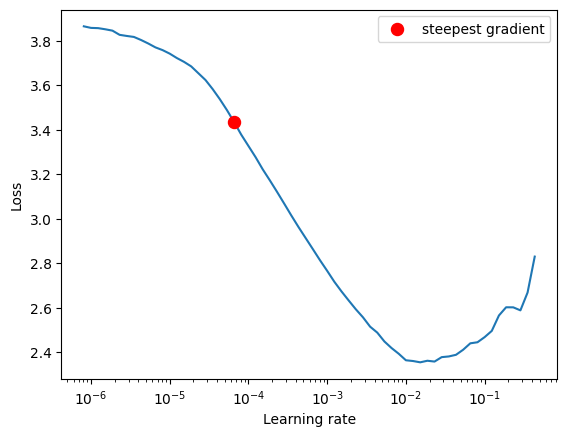

In [25]:
# LR finder with regularization
model = CustomResnet(inch=3, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-1)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_dl, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [34]:
model = CustomResnet(inch=3, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
criterion_test = nn.CrossEntropyLoss(reduction = 'sum')
optimizer = optim.Adam(model.parameters(), lr=2e-3,  weight_decay=1e-3)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=2e-3, epochs=EPOCHS, steps_per_epoch=1, \
                                          pct_start=0.2, div_factor=5)

train_stats = {}
test_stats = {}
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_epoch(model, device, train_dl, optimizer, criterion, epoch, train_stats)
    scheduler.step()
    test_epoch(model, device, test_dl, criterion_test, test_stats)


  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.0803993940353394 Batch_id=97 Accuracy=47.40: 100%|██████████████████████████████| 98/98 [00:12<00:00,  7.91it/s]
Loss=1.1204352378845215 Batch_id=0 Accuracy=59.96:   1%|▎                               | 1/98 [00:00<00:12,  7.69it/s]


Test set: Average loss: 1.1511, Accuracy: 5867/10000 (58.67%)

EPOCH: 1


Loss=0.8259543180465698 Batch_id=97 Accuracy=67.06: 100%|██████████████████████████████| 98/98 [00:12<00:00,  7.72it/s]
Loss=0.6994631290435791 Batch_id=0 Accuracy=77.15:   1%|▎                               | 1/98 [00:00<00:12,  7.49it/s]


Test set: Average loss: 0.7570, Accuracy: 7342/10000 (73.42%)

EPOCH: 2


Loss=0.6646963953971863 Batch_id=97 Accuracy=73.98: 100%|██████████████████████████████| 98/98 [00:14<00:00,  6.88it/s]
Loss=0.6165410876274109 Batch_id=0 Accuracy=79.30:   1%|▎                               | 1/98 [00:00<00:14,  6.85it/s]


Test set: Average loss: 0.6743, Accuracy: 7674/10000 (76.74%)

EPOCH: 3


Loss=0.5940371751785278 Batch_id=97 Accuracy=77.94: 100%|██████████████████████████████| 98/98 [00:14<00:00,  6.59it/s]
Loss=0.6503710150718689 Batch_id=0 Accuracy=79.69:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7500, Accuracy: 7538/10000 (75.38%)

EPOCH: 4


Loss=0.5603394508361816 Batch_id=97 Accuracy=81.31: 100%|██████████████████████████████| 98/98 [00:16<00:00,  5.92it/s]
Loss=0.4480467736721039 Batch_id=0 Accuracy=85.94:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6294, Accuracy: 7861/10000 (78.61%)

EPOCH: 5


Loss=0.4815370440483093 Batch_id=97 Accuracy=83.54: 100%|██████████████████████████████| 98/98 [00:18<00:00,  5.24it/s]
Loss=0.4224529266357422 Batch_id=0 Accuracy=85.94:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6172, Accuracy: 7907/10000 (79.07%)

EPOCH: 6


Loss=0.4965754449367523 Batch_id=97 Accuracy=84.71: 100%|██████████████████████████████| 98/98 [00:22<00:00,  4.44it/s]
Loss=0.39056286215782166 Batch_id=0 Accuracy=84.96:   1%|▎                              | 1/98 [00:00<00:15,  6.33it/s]


Test set: Average loss: 0.5245, Accuracy: 8237/10000 (82.37%)

EPOCH: 7


Loss=0.4477407932281494 Batch_id=97 Accuracy=85.79: 100%|██████████████████████████████| 98/98 [00:19<00:00,  4.92it/s]
Loss=0.32067275047302246 Batch_id=0 Accuracy=90.04:   1%|▎                              | 1/98 [00:00<00:16,  6.06it/s]


Test set: Average loss: 0.5261, Accuracy: 8235/10000 (82.35%)

EPOCH: 8


Loss=0.3730134963989258 Batch_id=97 Accuracy=86.91: 100%|██████████████████████████████| 98/98 [00:23<00:00,  4.20it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9160, Accuracy: 7336/10000 (73.36%)

EPOCH: 9


Loss=0.4136306643486023 Batch_id=97 Accuracy=87.78: 100%|██████████████████████████████| 98/98 [00:23<00:00,  4.22it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4687, Accuracy: 8441/10000 (84.41%)

EPOCH: 10


Loss=0.37636807560920715 Batch_id=97 Accuracy=88.33: 100%|█████████████████████████████| 98/98 [00:27<00:00,  3.57it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4752, Accuracy: 8420/10000 (84.20%)

EPOCH: 11


Loss=0.31336018443107605 Batch_id=97 Accuracy=89.13: 100%|█████████████████████████████| 98/98 [00:28<00:00,  3.44it/s]
Loss=0.24269717931747437 Batch_id=0 Accuracy=91.02:   1%|▎                              | 1/98 [00:00<00:15,  6.31it/s]


Test set: Average loss: 0.4027, Accuracy: 8660/10000 (86.60%)

EPOCH: 12


Loss=0.3489437401294708 Batch_id=97 Accuracy=89.98: 100%|██████████████████████████████| 98/98 [00:24<00:00,  4.03it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5077, Accuracy: 8292/10000 (82.92%)

EPOCH: 13


Loss=0.3176877498626709 Batch_id=97 Accuracy=90.93: 100%|██████████████████████████████| 98/98 [00:23<00:00,  4.19it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4174, Accuracy: 8621/10000 (86.21%)

EPOCH: 14


Loss=0.2957656681537628 Batch_id=97 Accuracy=91.69: 100%|██████████████████████████████| 98/98 [00:24<00:00,  4.08it/s]
Loss=0.18219396471977234 Batch_id=0 Accuracy=95.31:   1%|▎                              | 1/98 [00:00<00:15,  6.28it/s]


Test set: Average loss: 0.4094, Accuracy: 8657/10000 (86.57%)

EPOCH: 15


Loss=0.19423767924308777 Batch_id=97 Accuracy=92.81: 100%|█████████████████████████████| 98/98 [00:22<00:00,  4.44it/s]
Loss=0.15200193226337433 Batch_id=0 Accuracy=94.73:   1%|▎                              | 1/98 [00:00<00:15,  6.29it/s]


Test set: Average loss: 0.3330, Accuracy: 8898/10000 (88.98%)

EPOCH: 16


Loss=0.20925556123256683 Batch_id=97 Accuracy=93.63: 100%|█████████████████████████████| 98/98 [00:17<00:00,  5.63it/s]
Loss=0.18012075126171112 Batch_id=0 Accuracy=92.97:   1%|▎                              | 1/98 [00:00<00:15,  6.37it/s]


Test set: Average loss: 0.3130, Accuracy: 9006/10000 (90.06%)

EPOCH: 17


Loss=0.1323138177394867 Batch_id=97 Accuracy=94.62: 100%|██████████████████████████████| 98/98 [00:15<00:00,  6.52it/s]
Loss=0.10765144973993301 Batch_id=0 Accuracy=96.48:   1%|▎                              | 1/98 [00:00<00:14,  6.80it/s]


Test set: Average loss: 0.3161, Accuracy: 9001/10000 (90.01%)

EPOCH: 18


Loss=0.1381497085094452 Batch_id=97 Accuracy=96.01: 100%|██████████████████████████████| 98/98 [00:14<00:00,  6.54it/s]
Loss=0.1237594485282898 Batch_id=0 Accuracy=96.09:   1%|▎                               | 1/98 [00:00<00:14,  6.50it/s]


Test set: Average loss: 0.2566, Accuracy: 9194/10000 (91.94%)

EPOCH: 19


Loss=0.14875657856464386 Batch_id=97 Accuracy=96.83: 100%|█████████████████████████████| 98/98 [00:15<00:00,  6.53it/s]
Loss=0.07919993996620178 Batch_id=0 Accuracy=98.05:   1%|▎                              | 1/98 [00:00<00:15,  6.10it/s]


Test set: Average loss: 0.2407, Accuracy: 9252/10000 (92.52%)

EPOCH: 20


Loss=0.0969904288649559 Batch_id=97 Accuracy=97.51: 100%|██████████████████████████████| 98/98 [00:14<00:00,  6.68it/s]
Loss=0.11664631217718124 Batch_id=0 Accuracy=96.88:   1%|▎                              | 1/98 [00:00<00:14,  6.86it/s]


Test set: Average loss: 0.2299, Accuracy: 9284/10000 (92.84%)

EPOCH: 21


Loss=0.08551981300115585 Batch_id=97 Accuracy=98.04: 100%|█████████████████████████████| 98/98 [00:14<00:00,  6.72it/s]
Loss=0.05213812366127968 Batch_id=0 Accuracy=98.24:   1%|▎                              | 1/98 [00:00<00:15,  6.17it/s]


Test set: Average loss: 0.2172, Accuracy: 9316/10000 (93.16%)

EPOCH: 22


Loss=0.06619023531675339 Batch_id=97 Accuracy=98.26: 100%|█████████████████████████████| 98/98 [00:14<00:00,  6.60it/s]
Loss=0.07580714672803879 Batch_id=0 Accuracy=97.66:   1%|▎                              | 1/98 [00:00<00:15,  6.21it/s]


Test set: Average loss: 0.2161, Accuracy: 9323/10000 (93.23%)

EPOCH: 23


Loss=0.050961896777153015 Batch_id=97 Accuracy=98.44: 100%|████████████████████████████| 98/98 [00:14<00:00,  6.57it/s]



Test set: Average loss: 0.2168, Accuracy: 9324/10000 (93.24%)



**Summary**
- We achieved our target of test acc > 90% in epochs > 17 consistently
- Difference b/w train and test acc is < 5% (so within limits of overfitting target)